# Installation et import des librairies

- conda install -c conda-forge numpy
- conda install -c conda-forge pandas
- conda install -c anaconda scikit-learn
- conda install -c conda-forge scikit-learn-intelex
- conda install -c anaconda gensim  # python=3.8
- conda install -c conda-forge tensorflow-hub
- pip install --upgrade tensorflow-estimator==2.3.0
- conda install -c conda-forge matplotlib
- conda install -c anaconda seaborn

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import re
import math
import time
import warnings
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

## for preprocessing
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

## for classification
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

## for metrics
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

## for bag-of-words / Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for universal sentence encoder
import tensorflow_hub as hub

## Plotting tools
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

## dump
import joblib

C:\Users\james\anaconda3\envs\p5\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Chargement du jeu de données

In [4]:
data = pd.read_pickle('df_save.pkl')  

In [5]:
data.shape

(10243, 31)

In [6]:
data.columns

Index(['text', 'list_tokens', 'str_tokens', 'Dominant_Topic',
       'Perc_Contribution', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15',
       'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21',
       'topic_22', 'topic_23', 'topic_24', 'Tags_list'],
      dtype='object')

# Split

In [7]:
print('Split Dataset')
print('---------------------------------------------------------')
X_train, X_test = train_test_split(data, random_state=0, test_size=0.2)
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))

Split Dataset
---------------------------------------------------------
X_train: (8194, 31)
X_test: (2049, 31)


In [8]:
y_train = X_train[['Tags_list']]
y_test = X_test[['Tags_list']]
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))

y_train: (8194, 1)
y_test: (2049, 1)


# Target encoder

In [25]:
mlb = MultiLabelBinarizer()

In [26]:
y_train = mlb.fit_transform(y_train.Tags_list)

In [27]:
y_test = mlb.transform(y_test.Tags_list)

# Modélisation

## Modèles

In [12]:
model_list = list()
model_list.append(('LogisticRegression', LogisticRegression(max_iter=1000)))
model_list.append(('SGDClassifier', SGDClassifier()))
model_list.append(('HistGradientBoostingClassifier', HistGradientBoostingClassifier()))
model_list.append(('RandomForestClassifier', RandomForestClassifier()))

## Pipelines

In [13]:
# A CountVectorizer produces a sparse matrix and the HistGradientBoostingClassifier and 
# RandomForestClassifier require a dense matrix
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [14]:
def get_pipelines(feat_model, nb_features):
    pipelines = list()

    if feat_model == 'bow':
        for model_name, model in model_list:
            if model_name == 'LogisticRegression':
                pipe = Pipeline(steps=[
                    ('bow', CountVectorizer(
                        max_features=nb_features, ngram_range=(1, 2))),
                    ('scaler', StandardScaler(with_mean=False)),
                    ('clf', OneVsRestClassifier(model))
                ])

            elif model_name == 'SGDClassifier':
                pipe = Pipeline(steps=[
                    ('bow', CountVectorizer(
                        max_features=nb_features, ngram_range=(1, 2), )),
                    ('scaler', StandardScaler(with_mean=False)),
                    ('clf', ClassifierChain(model))
                ])

            else:
                pipe = Pipeline(steps=[
                    ('bow', CountVectorizer(
                        max_features=nb_features, ngram_range=(1, 2), )),
                    ('to_dense', DenseTransformer()),
                    ('scaler', StandardScaler(with_mean=False)),
                    ('clf', ClassifierChain(model))
                ])

            pipelines.append((model_name, pipe))

    elif feat_model == 'tfidf':
        for model_name, model in model_list:
            if model_name == 'LogisticRegression':
                pipe = Pipeline(steps=[
                    ('tfidf', TfidfVectorizer(
                        max_features=nb_features, ngram_range=(1, 2))),
                    ('scaler', StandardScaler(with_mean=False)),
                    ('clf', OneVsRestClassifier(model))
                ])

            elif model_name == 'SGDClassifier':
                pipe = Pipeline(steps=[
                    ('tfidf', TfidfVectorizer(
                        max_features=nb_features, ngram_range=(1, 2))),
                    ('scaler', StandardScaler(with_mean=False)),
                    ('clf', ClassifierChain(model))
                ])

            else:
                pipe = Pipeline(steps=[
                    ('tfidf', TfidfVectorizer(
                        max_features=nb_features, ngram_range=(1, 2))),
                    ('to_dense', DenseTransformer()),
                    ('scaler', StandardScaler(with_mean=False)),
                    ('clf', ClassifierChain(model))
                ])

            pipelines.append((model_name, pipe))

    else:
        for model_name, model in model_list:
            if model_name == 'LogisticRegression':
                if feat_model == 'w2v':
                    pipe = Pipeline(steps=[
                        ('scaler', QuantileTransformer()),
                        ('model', OneVsRestClassifier(model))
                    ])
                else:
                    pipe = Pipeline(steps=[
                        ('scaler', StandardScaler()),
                        ('model', OneVsRestClassifier(model))
                    ])
            else:
                pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('model', ClassifierChain(model))
                ])

            pipelines.append((model_name, pipe))

    return pipelines



# Extraction de tags

In [15]:
models = []

for model_name, model in model_list:
    models.append(re.sub('[^A-Z]', '', model_name))

In [16]:
def graphFitScore(model_list, data1, data2, ylabel, title, label1, label2):
    N = len(model_list) 

    ind = np.arange(N) 
    width = 0.35       
    plt.bar(ind, data1, width, label=label1)
    plt.bar(ind + width, data2, width, label=label2)
    
    plt.ylabel(ylabel)
    plt.title(title)

    plt.xticks(ind + width / 2, models)
    plt.legend(loc='best')
    plt.gcf().savefig(title, dpi=100)
    plt.show()

In [17]:
def graph(model_list, train, test, ylabel, title):
    N = len(model_list)

    ind = np.arange(N) 
    width = 0.35       
    plt.bar(ind, train, width, label='train')
    plt.bar(ind + width, test, width, label='test')

    plt.ylabel(ylabel)
    plt.title(title)

    plt.xticks(ind + width / 2, models)
    plt.legend(loc='best')
    plt.gcf().savefig(title, dpi=100)
    plt.show()

In [18]:
def eval_model(feat_model, nb_features, X, y, display):

    fit_times = ()
    score_times = ()
    scores_train = ()
    scores_test = ()
    grids = dict()

    # Evaluation
    for name, pipeline in get_pipelines(feat_model, nb_features):
        print('-------------------------------------------------------')
        print(name)
        print('-------------------------------------------------------')
        print('Start: ', time.asctime())

        grid = GridSearchCV(pipeline,
                            param_grid={},
                            scoring='f1_samples',
                            verbose=1,
                            cv=5,
                            n_jobs=-1,
                            return_train_score=True,
                            refit=True)

        grid.fit(X, y)

        mean_fit_time = grid.cv_results_['mean_fit_time'][grid.best_index_]
        fit_times = fit_times + (mean_fit_time,)
        if display:
            print('mean_fit_time: ' + str(mean_fit_time))

        mean_score_time = grid.cv_results_['mean_score_time'][grid.best_index_]
        score_times = score_times + (mean_score_time,)
        if display:
            print('mean_score_time: ' + str(mean_score_time))

        mean_train_score = grid.cv_results_['mean_train_score'][grid.best_index_]
        scores_train = scores_train + (mean_train_score,)
        if display:
            print('mean_train_score: ' + str(mean_train_score))

        mean_test_score = grid.cv_results_['mean_test_score'][grid.best_index_]
        scores_test = scores_test + (mean_test_score,)
        if display:
            print('mean_test_score: ' + str(mean_test_score))

        grids[name] = grid

        print('End: ', time.asctime())
        print('')

    # Graphs
    graphFitScore(model_list, fit_times, score_times, 'Time',
                  feat_model + ' - Fit et score times par modèle', 'fit_time', 'score_time')

    graph(model_list, scores_train, scores_test,
          'Scores', feat_model + ' - Scores par modèle')

    return grids

In [40]:
eval_acc = {}
eval_jac = {}
eval_f1 = {}

def evaluation(case, y_true, y_pred, average):
    global eval_acc, eval_jac, eval_f1
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:",  round(accuracy,3))
    
    # jacard
    jacard = jaccard_score(y_true, y_pred, average=average)
    print('Jacard:', round(jacard,3)) 
    
    # f1
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    print('F1:', round(f1,3)) 
    
    eval_acc[case] = accuracy    
    eval_jac[case] = jacard
    eval_f1[case] = f1

## Approche semi-supervisée

In [20]:
X_train_semi = X_train.loc[:, (X_train.columns != 'text') &
                              (X_train.columns != 'list_tokens') &
                              (X_train.columns != 'str_tokens') &
                              (X_train.columns != 'Tags_list')
                           ]
X_test_semi = X_test.loc[:, (X_test.columns != 'text') &
                            (X_test.columns != 'list_tokens') &
                            (X_test.columns != 'str_tokens') &
                            (X_test.columns != 'Tags_list')
                         ]
print('X_train_semi: ' + str(X_train_semi.shape))
print('X_test_semi: ' + str(X_test_semi.shape))

X_train_semi: (8194, 27)
X_test_semi: (2049, 27)


-------------------------------------------------------
LogisticRegression
-------------------------------------------------------
Start:  Sun Feb 20 15:41:09 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


End:  Sun Feb 20 15:41:11 2022

-------------------------------------------------------
SGDClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:41:11 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


End:  Sun Feb 20 15:41:15 2022

-------------------------------------------------------
HistGradientBoostingClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:41:15 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.0s finished


End:  Sun Feb 20 15:43:11 2022

-------------------------------------------------------
RandomForestClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:43:11 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


End:  Sun Feb 20 15:43:22 2022



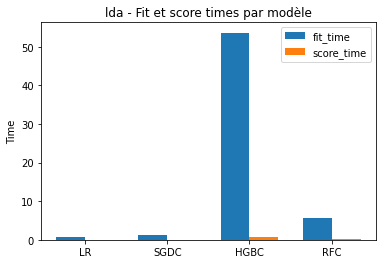

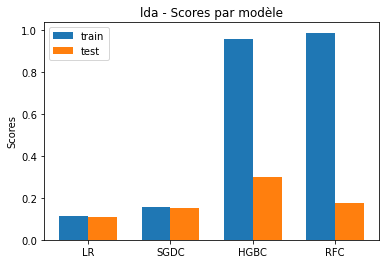

In [21]:
grids = eval_model('lda', None, X_train_semi, y_train, False)

In [22]:
lda = grids['SGDClassifier']

In [23]:
lda.fit(X_train_semi, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        ClassifierChain(base_estimator=SGDClassifier()))]),
             n_jobs=-1, param_grid={}, return_train_score=True,
             scoring='f1_samples', verbose=1)

In [24]:
predicted_semi = lda.predict(X_test_semi)

In [25]:
evaluation('lda', y_test, predicted_semi, 'samples')

Accuracy: 0.091
Jacard: 0.157
F1: 0.178


## Approche supervisée

In [9]:
nb_features = 200

### Bag of words

In [27]:
X_train_bow = X_train.str_tokens
X_test_bow = X_test.str_tokens

-------------------------------------------------------
LogisticRegression
-------------------------------------------------------
Start:  Sun Feb 20 15:43:25 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


End:  Sun Feb 20 15:43:34 2022

-------------------------------------------------------
SGDClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:43:34 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


End:  Sun Feb 20 15:43:38 2022

-------------------------------------------------------
HistGradientBoostingClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:43:38 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


End:  Sun Feb 20 15:50:26 2022

-------------------------------------------------------
RandomForestClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:50:26 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.0s finished


End:  Sun Feb 20 15:51:45 2022



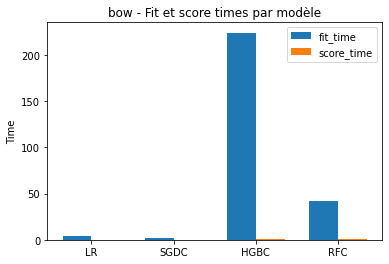

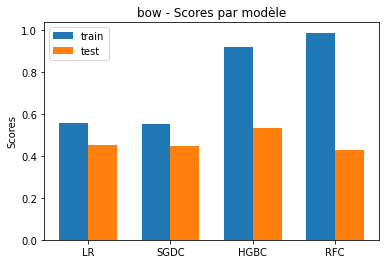

In [28]:
grids = eval_model('bow', nb_features, X_train_bow, y_train, False)

In [29]:
bow = grids['SGDClassifier']

In [30]:
bow.fit(X_train_bow, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(max_features=200,
                                                        ngram_range=(1, 2))),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('clf',
                                        ClassifierChain(base_estimator=SGDClassifier()))]),
             n_jobs=-1, param_grid={}, return_train_score=True,
             scoring='f1_samples', verbose=1)

In [31]:
y_pred_bow = bow.predict(X_test_bow)

In [32]:
evaluation('bow', y_test, y_pred_bow, 'samples')

Accuracy: 0.261
Jacard: 0.419
F1: 0.474


### Tf-Idf

In [14]:
X_train_tfidf = X_train.str_tokens
X_test_tfidf = X_test.str_tokens

-------------------------------------------------------
LogisticRegression
-------------------------------------------------------
Start:  Sun Feb 20 15:51:52 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


End:  Sun Feb 20 15:52:02 2022

-------------------------------------------------------
SGDClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:52:02 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


End:  Sun Feb 20 15:52:09 2022

-------------------------------------------------------
HistGradientBoostingClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:52:09 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


End:  Sun Feb 20 15:59:34 2022

-------------------------------------------------------
RandomForestClassifier
-------------------------------------------------------
Start:  Sun Feb 20 15:59:34 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


End:  Sun Feb 20 16:00:44 2022



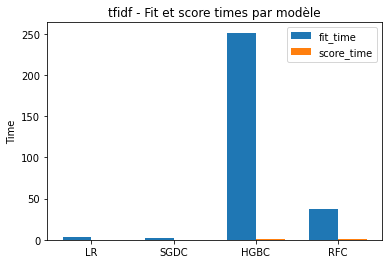

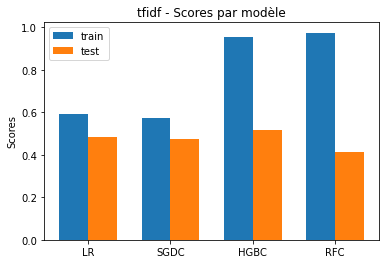

In [34]:
grids = eval_model('tfidf', nb_features, X_train_tfidf, y_train, False)

In [35]:
tfidf = grids['SGDClassifier']

In [36]:
tfidf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=200,
                                                        ngram_range=(1, 2))),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('clf',
                                        ClassifierChain(base_estimator=SGDClassifier()))]),
             n_jobs=-1, param_grid={}, return_train_score=True,
             scoring='f1_samples', verbose=1)

In [37]:
y_pred_tfidf = tfidf.predict(X_test_tfidf)

In [38]:
evaluation('tfidf', y_test, y_pred_tfidf, 'samples')

Accuracy: 0.271
Jacard: 0.439
F1: 0.499


### Word Embedding

In [39]:
# create corpus
corpus = data['str_tokens']

In [40]:
# create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_corpus.append(lst_words)

In [41]:
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=2, threshold=100)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

In [42]:
# fit w2v
w2v = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=nb_features,
                                      window=10, min_count=1, sg=0)

In [43]:
def drop(df, col_list):
    df = df.drop(col_list, axis=1)
    return df

In [44]:
def transform_w2v(X, nb_features):
    # Create a working copy of the dataset
    X = X.copy()
    
    # make sure indexes pair with number of rows
    X = X.reset_index()  
    X = drop(X, ['index'])
    
    # For each post, get the sum of w2v vector for each word
    result =[]

    for index, row in X.iterrows():
        try:
            sentence = row['str_tokens'].split(' ')
            sum_vectors = (0, )

            for word in sentence:
                # get word's vector
                vector = w2v.wv[word]
                # sum vector
                sum_vectors = sum_vectors + vector

            result.append(list(sum_vectors))
        except KeyError:
            result.append((0, ))
            
    result = np.array(result).tolist()
    
    # Add empty columns to dataframe
    columns_list = []
    for i in range(nb_features):
        columns_list.append('v_' + str(i))
    
    # Concat new columns with existing dataframe
    X = pd.concat(
        [
            X,
            pd.DataFrame(
                result, 
                index=X.index, 
                columns=columns_list
            )
        ], axis=1
    )
    
    # If nan value, fill with 0
    X = X.fillna(0)
            
    # Filter
    X = X[columns_list]
    
    return X

In [45]:
X_train_w2v = transform_w2v(X_train, nb_features)

In [46]:
X_test_w2v = transform_w2v(X_test, nb_features)

-------------------------------------------------------
LogisticRegression
-------------------------------------------------------
Start:  Sun Feb 20 16:00:58 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.4s finished


End:  Sun Feb 20 16:01:36 2022

-------------------------------------------------------
SGDClassifier
-------------------------------------------------------
Start:  Sun Feb 20 16:01:36 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.6s finished


End:  Sun Feb 20 16:02:21 2022

-------------------------------------------------------
HistGradientBoostingClassifier
-------------------------------------------------------
Start:  Sun Feb 20 16:02:21 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


End:  Sun Feb 20 16:10:16 2022

-------------------------------------------------------
RandomForestClassifier
-------------------------------------------------------
Start:  Sun Feb 20 16:10:16 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


End:  Sun Feb 20 16:10:42 2022



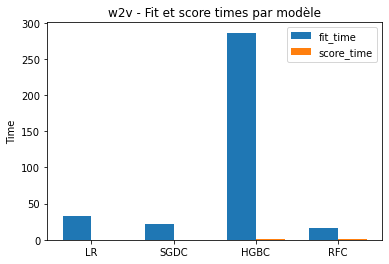

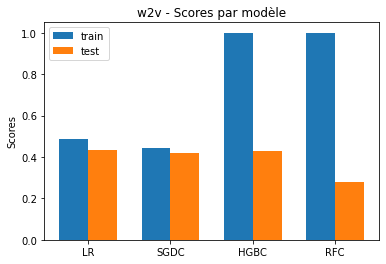

In [47]:
grids = eval_model('w2v', None, X_train_w2v, y_train, False)

In [48]:
w2v = grids['SGDClassifier']

In [49]:
w2v.fit(X_train_w2v, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        ClassifierChain(base_estimator=SGDClassifier()))]),
             n_jobs=-1, param_grid={}, return_train_score=True,
             scoring='f1_samples', verbose=1)

In [50]:
predicted_w2v = w2v.predict(X_test_w2v)

In [51]:
evaluation('w2v', y_test, predicted_w2v, 'samples')

Accuracy: 0.24
Jacard: 0.382
F1: 0.432


### Universal sentence encoder

In [52]:
# Load pre-trained universal sentence encoder model
universal = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [53]:
def transform_uni(X):
    # Create a working copy of the dataset
    X = X.copy()
    
    # Make sure indexes pair with number of rows
    X = X.reset_index()  
    X = drop(X, ['index'])
    
    # For each post, get the sentence vector 
    sentences = []
    for index, row in X.iterrows():
        sentences.append(row['str_tokens'])
    
    # Get universal sentence encoder vectors
    message_embeddings = universal(sentences)
    result = np.array(message_embeddings).tolist()        
    
    # Create new columns list
    columns_list = []
    for i in range(512):
        columns_list.append('v_' + str(i))
    
    # Concat new columns with existing dataframe
    X = pd.concat(
        [
            X,
            pd.DataFrame(
                result, 
                index=X.index, 
                columns=columns_list
            )
        ], axis=1
    )
    
    # If nan value, fill with 0
    X = X.fillna(0)
    
    # Filter
    X = X[columns_list]
    
    return X

In [54]:
X_train_uni = transform_uni(X_train)

In [55]:
X_test_uni = transform_uni(X_test)

-------------------------------------------------------
LogisticRegression
-------------------------------------------------------
Start:  Sun Feb 20 16:11:45 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


End:  Sun Feb 20 16:13:18 2022

-------------------------------------------------------
SGDClassifier
-------------------------------------------------------
Start:  Sun Feb 20 16:13:18 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s finished


End:  Sun Feb 20 16:14:45 2022

-------------------------------------------------------
HistGradientBoostingClassifier
-------------------------------------------------------
Start:  Sun Feb 20 16:14:45 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.8min finished


End:  Sun Feb 20 16:32:54 2022

-------------------------------------------------------
RandomForestClassifier
-------------------------------------------------------
Start:  Sun Feb 20 16:32:54 2022
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.8s finished


End:  Sun Feb 20 16:33:56 2022



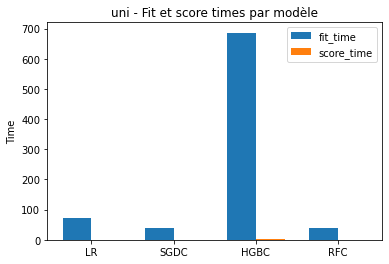

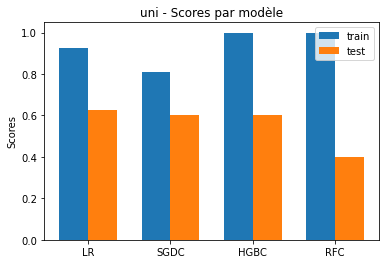

In [56]:
grids = eval_model('uni', None, X_train_uni, y_train, False)

In [57]:
uni = grids['SGDClassifier']

In [58]:
uni.fit(X_train_uni, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        ClassifierChain(base_estimator=SGDClassifier()))]),
             n_jobs=-1, param_grid={}, return_train_score=True,
             scoring='f1_samples', verbose=1)

In [59]:
predicted_uni = uni.predict(X_test_uni)

In [60]:
evaluation('uni', y_test, predicted_uni, 'samples')

Accuracy: 0.335
Jacard: 0.548
F1: 0.619


# Résultat final

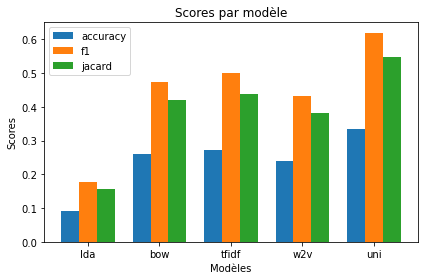

In [61]:
ind = np.arange(5) 
width = 0.25       
plt.bar(ind, eval_acc.values(), width, label='accuracy')
plt.bar(ind + width, eval_f1.values(), width, label='f1')
plt.bar(ind + (width * 2), eval_jac.values(), width, label='jacard')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Scores par modèle')

plt.xticks(ind + width, ['lda', 'bow', 'tfidf', 'w2v', 'uni'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('test_result', dpi=100)
plt.show()

# Tuning du modèle choisi

##### Je choisis d'implémenter en production le modèle utilisant TF-IDF et SGDClassifier pour les raisons ci-dessous:

- Test score plus bas que universal sentence encoder mais celui-ci ne peut être implémenter en production (tensorflow)
- Fit time de SGDClassifier bien plus bas

In [33]:
params = {'scaler': [StandardScaler(with_mean=False), QuantileTransformer()],
          'tfidf__max_features': [128, 256, 512],
          'clf__base_estimator__penalty': ['l2', 'l1', 'elasticnet'],
          'clf__base_estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
          'clf__base_estimator__alpha': [1e-5, 1e-4],
          'clf__base_estimator__max_iter': [1000, 2000, 5000],
          'clf__base_estimator__tol': [1e-4, 1e-3, 1e-2],
          'clf__base_estimator__early_stopping': [True]}

In [34]:
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(
        max_features=nb_features, ngram_range=(1, 2))),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', ClassifierChain(SGDClassifier()))
])

In [35]:
grid = GridSearchCV(pipe,
                    param_grid=params,
                    scoring='f1_samples',
                    verbose=1,
                    cv=5,
                    n_jobs=-1,
                    refit=True)

In [36]:
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 37.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=200,
                                                        ngram_range=(1, 2))),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('clf',
                                        ClassifierChain(base_estimator=SGDClassifier()))]),
             n_jobs=-1,
             param_grid={'clf__base_estimator__alpha': [1e-05, 0.0001],
                         'clf__base_estimator__early_stopping': [True],
                         'clf__base_estimator__loss': ['hinge', 'log',
                                                       'modified_huber',
                                                       'squared_hinge',
                                                       'perceptron'],
                         'clf__base_estimator__max_iter': [1000

In [37]:
grid.best_params_

{'clf__base_estimator__alpha': 0.0001,
 'clf__base_estimator__early_stopping': True,
 'clf__base_estimator__loss': 'log',
 'clf__base_estimator__max_iter': 5000,
 'clf__base_estimator__penalty': 'elasticnet',
 'clf__base_estimator__tol': 0.01,
 'scaler': QuantileTransformer(),
 'tfidf__max_features': 512}

In [38]:
y_pred_tfidf = grid.predict(X_test_tfidf)

In [41]:
evaluation('tfidf', y_test, y_pred_tfidf, 'samples')

Accuracy: 0.377
Jacard: 0.55
F1: 0.608


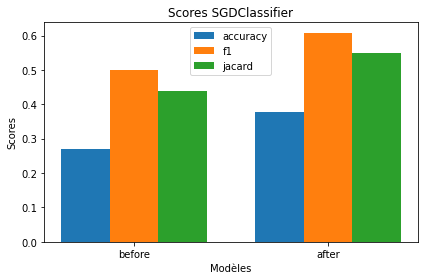

In [43]:
accuracy = np.array([0.271, 0.377])
jacard = np.array([0.439, 0.55])
f1 = np.array([0.499, 0.608])

ind = np.arange(2) 
width = 0.25       
plt.bar(ind, accuracy, width, label='accuracy')
plt.bar(ind + width, f1, width, label='f1')
plt.bar(ind + (width * 2), jacard, width, label='jacard')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Scores SGDClassifier')

plt.xticks(ind + width, ['before', 'after'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('tuning_result', dpi=100)
plt.show()

# Sauvegardes

In [44]:
joblib.dump(mlb, 'mlb.jl')

['mlb.jl']

In [47]:
joblib.dump(tfidf, 'tfidf.jl')

['tfidf.jl']
